In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [38]:
# Generating data
N = 100
L = 1000
T = 20

x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
y = np.sin(x/T).astype(np.float32)

print(y.shape)

(100, 1000)


In [52]:

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

In [63]:
class LSTMPredictor(nn.Module):
  def __init__(self, n_hidden=51):
      super(LSTMPredictor, self).__init__()
      self.n_hidden = n_hidden

      self.lstm1 = nn.LSTMCell(1, self.n_hidden)
      self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
      self.linear = nn.Linear(self.n_hidden, 1)

  def forward(self, x, future=0):
      outputs = []
      n_samples = x.size(0)

      h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
      c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
      h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
      c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

      for input_t in x.split(1, dim=1):
          h_t, c_t = self.lstm1(input_t, (h_t, c_t))
          h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
          output = self.linear(h_t2)
          outputs.append(output)
      
      for i in range(future):
          h_t, c_t = self.lstm1(output, (h_t, c_t))
          h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
          output = self.linear(h_t2)
          outputs.append(output)

      outputs = torch.cat(outputs, dim=1)
      return outputs

In [64]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [65]:
device = get_default_device()

In [70]:
def draw(y, color):
  plt.title(f'Step {i+1}')
  plt.xlabel('x')
  plt.ylabel('y')
  n = train_input.shape[1]
  plt.plot(np.arange(n), y[:n], color)
  plt.plot(np.arange(n, n+future), y[n:], color+':')

Step  0


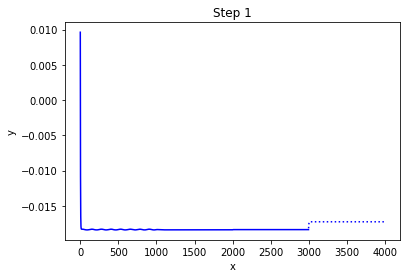

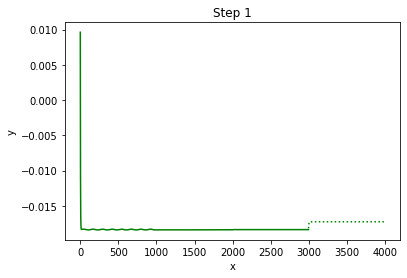

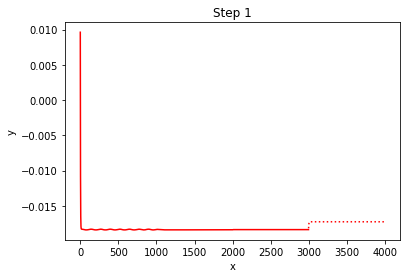

Step  1


In [ ]:

train_input = torch.from_numpy(y[3:, :-1]).to(device)
train_target = torch.from_numpy(y[3:, 1:]).to(device)

test_input = torch.from_numpy(y[:3, :-1]).to(device)
test_target = torch.from_numpy(y[:3, 1:]).to(device)

model = LSTMPredictor().to(device)
criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr =0.5)

n_steps = 10
for i in range(n_steps):
  print("Step ", i)

  def closure():
    optimizer.zero_grad()
    out = model(train_input)
    loss = criterion(out, train_target)
    loss.backward()
    return loss
  optimizer.step(closure)

  with torch.no_grad():
    future = 1000
    pred = model(test_input, future=future)
    loss = criterion(pred[:, :-future], test_target)
    y = pred.detach().numpy()

  for y_i,c in zip(y, ['b', 'g', 'r']):
    draw(y_i, c)
    plt.show()
